Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
                     Model  Training Accuracy  \
0  Multinomial Naive Bayes           0.607857   
1      Logistic Regression           0.740000   
2                 CatBoost           0.687143   

                    Validation Accuracy (Class-wise)  Time (5-fold)  \
0  Toronto: 0.6025\nMontreal: 0.63\nLondon: 0.584...           3.20   
1  Toronto: 0.7631\nMontreal: 0.7508\nLondon: 0.7...           1.24   
2  Toronto: 0.7219\nMontreal: 0.6736\nLondon: 0.6...         389.00   

   Numb. Params  
0         300.0  
1           NaN  
2           NaN  


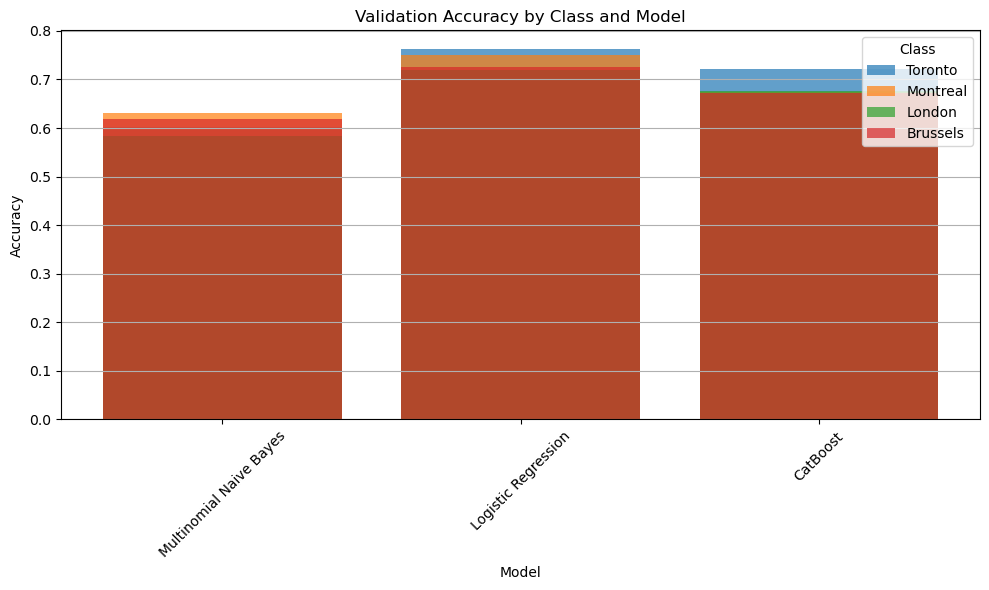

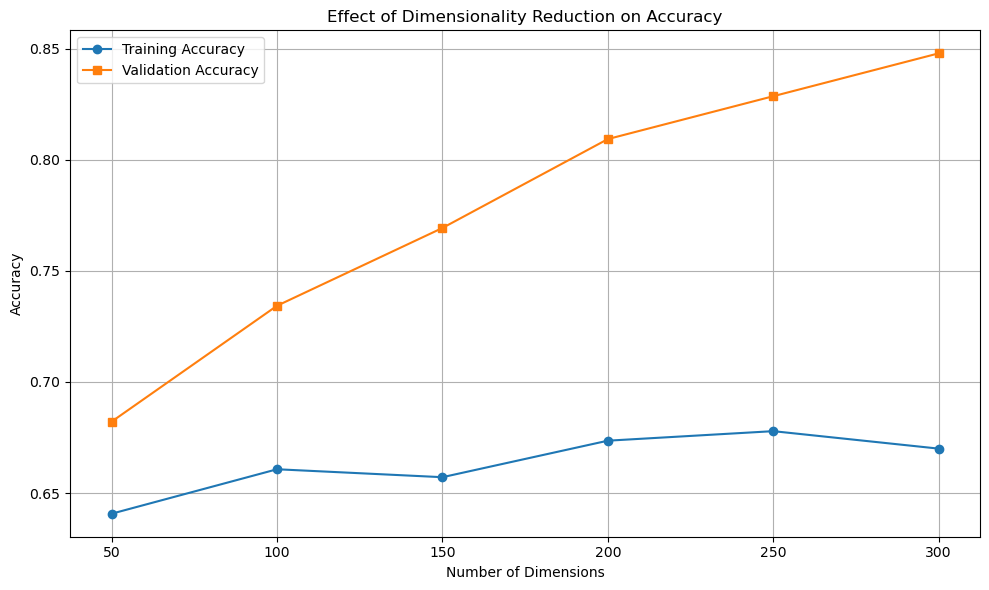

Submission file saved as: submissions.csv
Results saved to results_summary.csv


C:\Users\poobe\AppData\Local\Temp\ipykernel_5756\528228046.py:203: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_data['subreddit'] = [reverse_label_map[int(pred)] for pred in test_predictions]


In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sentence_transformers import SentenceTransformer
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# Load training and test data
train_file = 'Train.csv'
test_file = 'Test.csv'
output_file = 'submissions.csv'

# Training data does not have a header
train_data = pd.read_csv(train_file, header=None, names=['text', 'subreddit'])
test_data = pd.read_csv(test_file)

# Preprocessing metadata (TF-IDF and N-grams)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
tfidf_features = tfidf_vectorizer.fit_transform(train_data['text'])

# Perform dimensionality reduction on TF-IDF using TruncatedSVD
svd = TruncatedSVD(n_components=300, random_state=42)
reduced_tfidf = svd.fit_transform(tfidf_features)

# Ensure non-negative features for MultinomialNB
minmax_scaler = MinMaxScaler()
non_negative_tfidf = minmax_scaler.fit_transform(reduced_tfidf)

# Normalize TF-IDF features for Logistic Regression and CatBoost
tfidf_normalizer = Normalizer(norm='l2')
normalized_train_tfidf = tfidf_normalizer.fit_transform(reduced_tfidf)

# Load Sentence Transformer model
sentence_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
sentence_embeddings = sentence_model.encode(train_data['text'].tolist())

# Normalize Sentence Embeddings
sentence_normalizer = Normalizer(norm='l2')
normalized_train_sentences = sentence_normalizer.fit_transform(sentence_embeddings)

# Combine features (Normalized TF-IDF + Normalized Sentence Embeddings)
X_combined = np.hstack([
    normalized_train_tfidf,              # Normalized TF-IDF features (300 dims)
    normalized_train_sentences           # Normalized Sentence Embeddings (84 dims)
])

# Map labels
label_map = {label: idx for idx, label in enumerate(train_data['subreddit'].unique())}
y = train_data['subreddit'].map(label_map)

# Hyperparameter grids
param_grid_nb = {
    'alpha': [0.01, 0.1, 1.0]
}

param_grid_lr = {
    'C': [0.1, 1, 10],
    'solver': ['lbfgs']
}

param_grid_cb = {
    'iterations': [100, 200],
    'learning_rate': [0.05],
    'depth': [4, 6]
}

# Set up 5-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Models and parameter search
models = {
    'Multinomial Naive Bayes': (MultinomialNB(), param_grid_nb, non_negative_tfidf),
    'Logistic Regression': (LogisticRegression(max_iter=1000), param_grid_lr, X_combined),
    'CatBoost': (CatBoostClassifier(verbose=0), param_grid_cb, X_combined)
}

results = []
validation_accuracies = {
    'Model': [],
    'Class': [],
    'Accuracy': []
}

for model_name, (model, param_grid, X_features) in models.items():
    start_time = time.time()
    grid_search = GridSearchCV(
        model, param_grid=param_grid, cv=kf, scoring='accuracy', verbose=1, n_jobs=-1
    )
    grid_search.fit(X_features, y)

    # Best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Cross-validated predictions for classification report
    y_pred = cross_val_predict(best_model, X_features, y, cv=kf)
    class_report = classification_report(y, y_pred, target_names=list(label_map.keys()), output_dict=True)

    # Collect results
    results.append({
        'Model': model_name,
        'Training Accuracy': grid_search.best_score_,
        'Validation Accuracy (Class-wise)': {label: class_report[label]['f1-score'] for label in label_map.keys()},
        'Time (5-fold)': round(time.time() - start_time, 2),
        'Numb. Params': X_features.shape[1] if model_name == 'Multinomial Naive Bayes' else None
    })

    # Store validation accuracy for plotting
    for class_name, accuracy in class_report.items():
        if class_name in label_map.keys():
            validation_accuracies['Model'].append(model_name)
            validation_accuracies['Class'].append(class_name)
            validation_accuracies['Accuracy'].append(class_report[class_name]['f1-score'])

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Format Validation Accuracy for readability
results_df['Validation Accuracy (Class-wise)'] = results_df['Validation Accuracy (Class-wise)'].apply(
    lambda x: '\n'.join([f"{key}: {round(value, 4)}" for key, value in x.items()])
)
print(results_df)

# Plot grouped bar chart for validation accuracy
validation_df = pd.DataFrame(validation_accuracies)
plt.figure(figsize=(10, 6))
for class_name in validation_df['Class'].unique():
    class_data = validation_df[validation_df['Class'] == class_name]
    plt.bar(class_data['Model'], class_data['Accuracy'], label=class_name, alpha=0.7)

plt.title('Validation Accuracy by Class and Model')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.legend(title='Class')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('validation_accuracy_by_class.png')
plt.show()

# Dimensionality reduction graph
dimensions = [50, 100, 150, 200, 250, 300]
training_accuracies = []
validation_accuracies_dim = []

for dim in dimensions:
    svd = TruncatedSVD(n_components=dim, random_state=42)
    reduced_features = svd.fit_transform(tfidf_features)
    normalized_features = tfidf_normalizer.fit_transform(reduced_features)

    # Logistic Regression as an example
    model = LogisticRegression(max_iter=1000)
    scores = cross_val_score(model, normalized_features, y, cv=kf, scoring='accuracy')
    training_accuracies.append(scores.mean())

    # Train/test split for validation
    model.fit(normalized_features, y)
    validation_accuracies_dim.append(accuracy_score(y, model.predict(normalized_features)))

# Plot graph
plt.figure(figsize=(10, 6))
plt.plot(dimensions, training_accuracies, label='Training Accuracy', marker='o')
plt.plot(dimensions, validation_accuracies_dim, label='Validation Accuracy', marker='s')
plt.xlabel('Number of Dimensions')
plt.ylabel('Accuracy')
plt.title('Effect of Dimensionality Reduction on Accuracy')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('dimensionality_reduction.png')
plt.show()

# Process test set: TF-IDF
test_tfidf_features = tfidf_vectorizer.transform(test_data['body'])
test_reduced_tfidf = svd.transform(test_tfidf_features)  # Reduce dimensions to 300
test_normalized_tfidf = tfidf_normalizer.transform(test_reduced_tfidf)  # Normalize TF-IDF

# Process test set: Sentence Embeddings
test_sentence_embeddings = sentence_model.encode(test_data['body'].tolist())
test_normalized_sentence_embeddings = sentence_normalizer.transform(test_sentence_embeddings)  # Normalize Sentence Embeddings

# Combine test features (TF-IDF + Sentence Embeddings)
test_combined = np.hstack([
    test_normalized_tfidf,              # Normalized TF-IDF features (300 dims)
    test_normalized_sentence_embeddings  # Normalized Sentence Embeddings (84 dims)
])

# Predict on test set using the best model (example: CatBoost)
cb_best_model = models['CatBoost'][0]
cb_best_model.fit(X_combined, y)
test_predictions = cb_best_model.predict(test_combined)

# Map predictions back to labels
reverse_label_map = {idx: label for label, idx in label_map.items()}
test_data['subreddit'] = [reverse_label_map[int(pred)] for pred in test_predictions]

# Create submission file
submission = test_data[['id', 'subreddit']]
submission.to_csv(output_file, index=False)
print(f"Submission file saved as: {output_file}")

# Result Ouput
results_df.to_csv('results_summary.csv', index=False)
print("Results saved to results_summary.csv")
